In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### Data import

In [2]:
vk_data = pd.read_csv("data/vehicle-kilometres_data.csv", sep=";", index_col="ID")
vk_meta = pd.read_csv("data/vehicle-kilometres_typ_meta.csv", sep=";", skiprows=1, index_col="Key")

vehicle_type = vk_data["TypesOfVehicle"].array.copy()
for i in range(len(vehicle_type)):
    vehicle_type[i] = vk_meta.loc[vehicle_type[i], "Title"]
    
vk_data["TypesOfVehicle"] = vehicle_type
vk_data["Periods"] = vk_data["Periods"].apply(lambda s: int(s[0:4]))
vk_data.drop(columns=vk_data.columns.to_list()[3:], inplace=True)
vk_data.rename(columns={"TypesOfVehicle":"Vehicle Type", "Periods":"Year", "TotalKilometresInTheNetherlands_1":"vhkm"}, inplace=True)

In [3]:
ems_data = pd.read_csv("data/emissions_data.csv", sep=";", index_col="ID")
ems_source_meta = pd.read_csv("data/emissions_source_meta.csv", sep=";", skiprows=1, index_col="Key")
ems_emission_meta = pd.read_csv("data/emissions_emission_meta.csv", sep=";", skiprows=1, index_col="Key")

sources = ems_data["Sources"].array.copy()
emissions = ems_data["Emissions"].array.copy()
for i in range(len(sources)):
    sources[i] = ems_source_meta.loc[sources[i], "Title"]
    emissions[i] = ems_emission_meta.loc[emissions[i], "Title"]
    
ems_data["Sources"] = sources
ems_data["Emissions"] = emissions
ems_data["Periods"] = ems_data["Periods"].apply(lambda s: int(s[0:4]))
ems_data.rename(columns={"Emissions":"Emission Type", "Periods":"Year", "EmissionsDutchTerritory_1":"Emission"}, inplace=True)

In [4]:
print(vk_data["Vehicle Type"].unique())
print()
print(ems_data["Sources"].unique())
print()
print(ems_data["Emission Type"].unique())

['Total motor vehicles' 'Passenger car' 'Delivery van'
 'Lorry (road tractor not included)' 'Road tractor'
 'Special purpose vehicle' 'Bus']

['Total mobile sources' 'Total inland transport' 'Road traffic, total'
 'Road traffic, passenger cars' 'Road traffic, freight vehicles'
 'Road traffic, other' 'Total inland shipping'
 'Inland shipping, passenger transport'
 'Inland shipping, freight transport' 'Inland shipping, pleasure cruising'
 'Fishing' 'Railways total' 'Railways, passenger transport'
 'Railways, freight transport' 'Aviation' 'Seagoing shipping, inland'
 'Seagoing shipping on continental shelf' 'Mobile machinery, total'
 'Mobile machinery, agriculture' 'Mobile machinery, building industry'
 'Mobile machinery, other sectors']

['Carbon dioxide (CO2)' 'Carbon monoxide (CO)'
 'VOC emission by combustion' 'VOC emission by evaporation'
 'Volatile organic compounds (VOC)' 'Methane (CH4)' 'NMVOS'
 'Nitrogen oxides (NOx)' 'Dinitrogen oxide (N2O)' 'Sulphur dioxide (SO2)'
 'PM10 (Parti

In [16]:
def getCategory(df, cat_name, cat, sum_cat):
    bools = np.empty(len(df[cat_name]), dtype=bool)
    for i in range(len(cat)):
        bools = np.logical_or(bools, df[cat_name] == cat[i])
        
    if sum_cat:
        df = df[bools].groupby("Year").sum()
        df["Year"] = df.index.array
        df.index.names = ["Not_Year"]
        return df
    else:
        return df[bools]

    

vk_data_car = getCategory(vk_data, "Vehicle Type", ["Delivery van", "Lorry (road tractor not included)", "Road tractor"], True)
# vk_data_car = vk_data[vk_data["Vehicle Type"] == "Passenger car"]

ems_data = getCategory(ems_data, "Emission Type", ["Carbon dioxide (CO2)", "Carbon monoxide (CO)", "PM10 (Particulate matter)", "Nitrogen oxides (NOx)"], False)
ems_data_car = ems_data[ems_data["Sources"] == "Road traffic, freight vehicles"]

In [18]:
car_data = ems_data_car.merge(right = vk_data_car, how="left", on="Year")
car_data["e/km"] = car_data["Emission"] / car_data["vhkm"]

display(car_data)

,Sources,Emission Type,Year,Emission,vhkm,e/km
0,"Road traffic, freight vehicles",Carbon dioxide (CO2),1990,7600.0,13542.0,0.561217
1,"Road traffic, freight vehicles",Carbon dioxide (CO2),1991,7900.0,14363.0,0.550024
2,"Road traffic, freight vehicles",Carbon dioxide (CO2),1992,8400.0,15650.0,0.536741
3,"Road traffic, freight vehicles",Carbon dioxide (CO2),1993,8500.0,16572.0,0.512913
4,"Road traffic, freight vehicles",Carbon dioxide (CO2),1994,8500.0,16647.0,0.510603
...,...,...,...,...,...,...
123,"Road traffic, freight vehicles",PM10 (Particulate matter),2017,1.7,25119.3,0.000068
124,"Road traffic, freight vehicles",PM10 (Particulate matter),2018,1.6,25686.6,0.000062
125,"Road traffic, freight vehicles",PM10 (Particulate matter),2019,1.5,26186.8,0.000057
126,"Road traffic, freight vehicles",PM10 (Particulate matter),2020,1.5,25544.5,0.000059


### Graphs and stuff

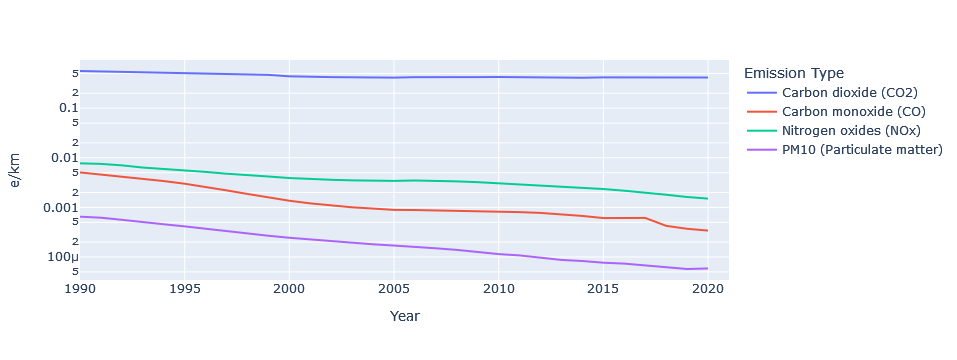

In [19]:
px.line(car_data, x="Year", y="", color="Emission Type", log_y=True)

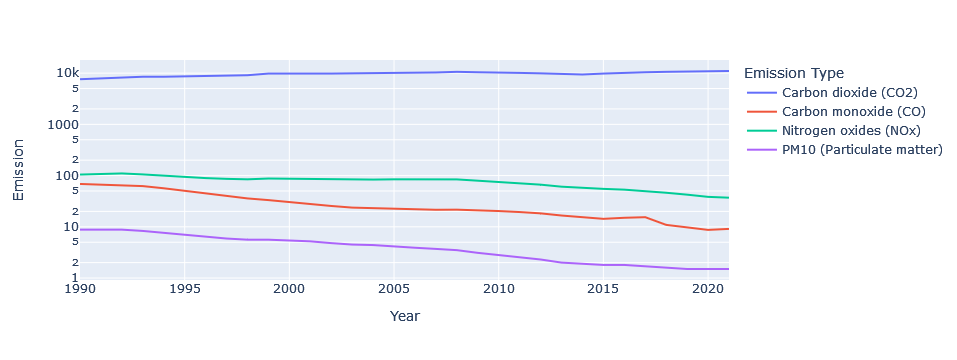

In [20]:
px.line(car_data, x="Year", y="Emission", color="Emission Type", log_y=True)

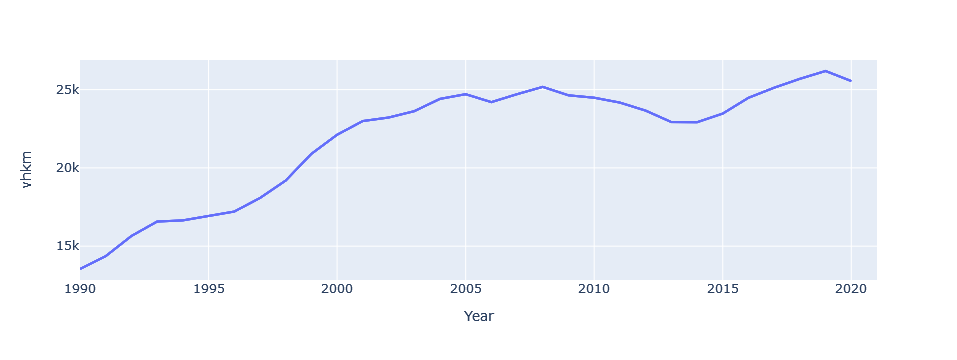

In [21]:
px.line(car_data, x="Year", y="vhkm")

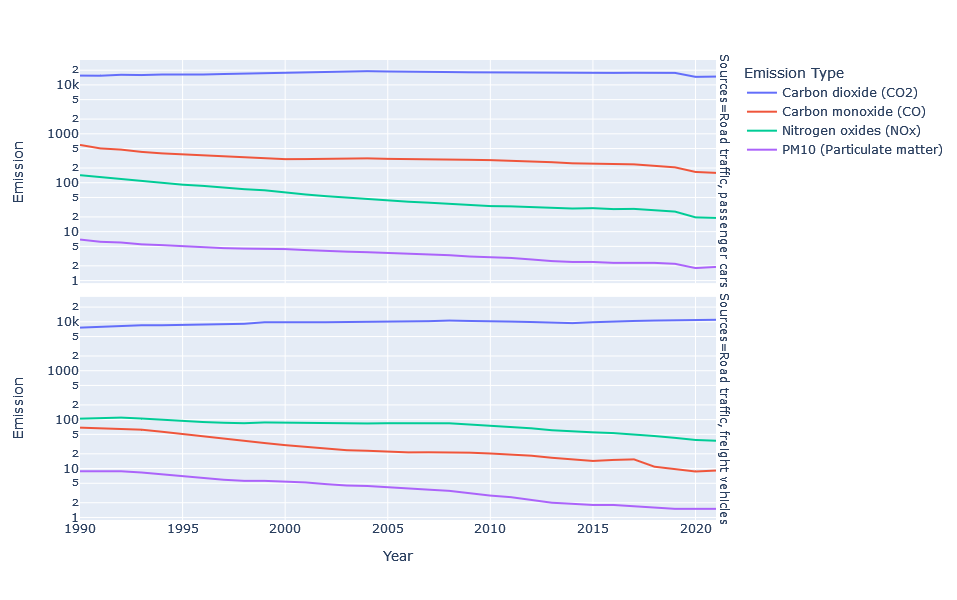

In [22]:
# display(ems_data)
ems_data_reduced = ems_data[np.logical_or(ems_data["Sources"] == "Road traffic, passenger cars", ems_data["Sources"] == "Road traffic, freight vehicles")]
px.line(ems_data_reduced, x="Year", y="Emission", color="Emission Type", facet_row="Sources", log_y=True, height=600)

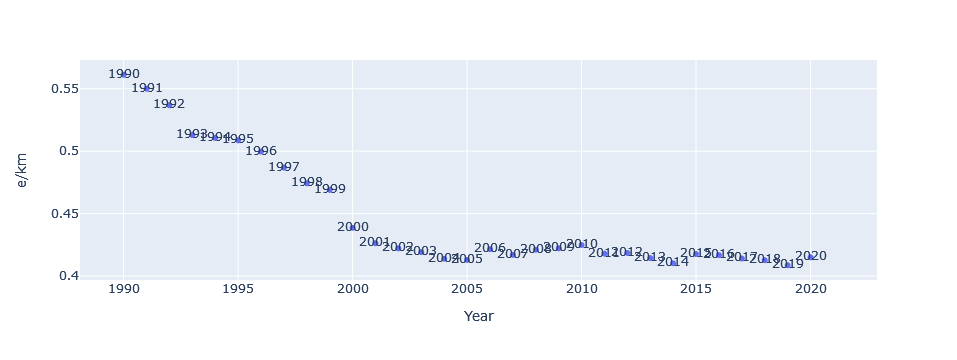

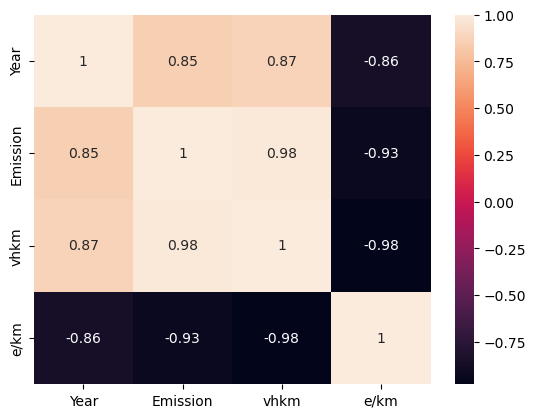

In [36]:
car_data_PM10 = car_data[car_data["Emission Type"] == "Carbon dioxide (CO2)"]
# car_data_PM10 = car_data_PM10[car_data_PM10["Year"] >= 2002]
# car_data_PM10 = car_data_PM10[car_data_PM10["Year"] <= 2020]

car_data_PM10_hm = car_data_PM10.corr(method="pearson")
sns.heatmap(car_data_PM10_hm, annot=True)

px.scatter(car_data_PM10, x="Year", y="e/km", text="Year")

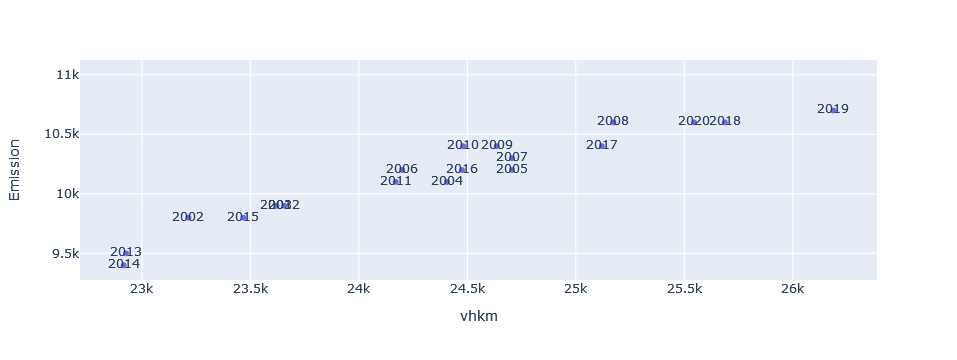

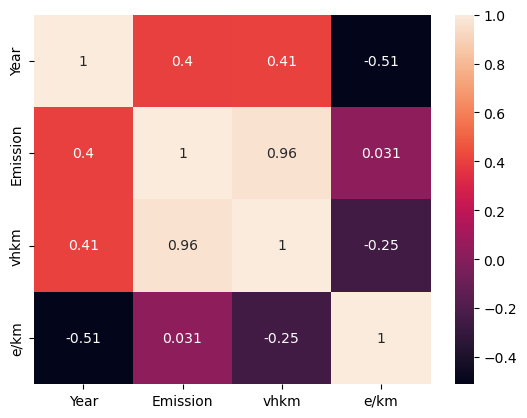

In [39]:
car_data_PM10 = car_data[car_data["Emission Type"] == "Carbon dioxide (CO2)"]
car_data_PM10 = car_data_PM10[car_data_PM10["Year"] >= 2002]
# car_data_PM10 = car_data_PM10[car_data_PM10["Year"] <= 2020]

car_data_PM10_hm = car_data_PM10.corr(method="pearson")
sns.heatmap(car_data_PM10_hm, annot=True)

px.scatter(car_data_PM10, x="vhkm", y="Emission", text="Year")